<a href="https://colab.research.google.com/github/MatteoFalzi/Falzi-Tesi/blob/master/01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inicialization**


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# first some extra packages we're gonna need
!pip3 install coloredlogs
!pip install -q git+https://github.com/tensorflow/examples.git

%tensorflow_version 2.x
import tensorflow as tf

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import numpy as np 
from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import (Activation, AveragePooling2D,
                                            BatchNormalization, Conv2D, Conv3D,
                                            Dense, Flatten,
                                            GlobalAveragePooling2D,
                                            GlobalMaxPooling2D, Input,
                                            MaxPooling2D, MaxPooling3D,
                                            Reshape, Dropout, concatenate,
											                      UpSampling2D, Conv2DTranspose)
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K_B
import coloredlogs
from os.path import exists
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

from numpy import ceil, log2
from collections import deque


#os.environ["CUDA_VISIBLE_DEVICES"]="0"

print(tf.__version__)



2.2.0


# **Soft normalized cut loss implementation**

In [13]:
def edge_weights(flatten_image, rows , cols, std_intensity=3, std_position=1, radius=5):
	'''
	Inputs :
	flatten_image : 1 dim tf array of the row flattened image ( intensity is the average of the three channels) 
	std_intensity : standard deviation for intensity 
	std_position : standard devistion for position
	radius : the length of the around the pixel where the weights 
	is non-zero
	rows : rows of the original image (unflattened image)
	cols : cols of the original image (unflattened image)

	Output : 
	weights :  2d tf array edge weights in the pixel graph

	Used parameters :
	n : number of pixels 
	'''
	A = outer_product(flatten_image, tf.ones_like(flatten_image))
	A_T = tf.transpose(A)
	intensity_weight = tf.exp(-1*tf.square((tf.divide((A - A_T), std_intensity))))

	xx, yy = tf.meshgrid(tf.range(rows), tf.range(cols))
	xx = tf.reshape(xx, (rows*cols,))
	yy = tf.reshape(yy, (rows*cols,))
	A_x = outer_product(xx, tf.ones_like(xx))
	A_y = outer_product(yy, tf.ones_like(yy))

	xi_xj = A_x - tf.transpose(A_x)
	yi_yj = A_y - tf.transpose(A_y)

	sq_distance_matrix = tf.square(xi_xj) + tf.square(yi_yj)

	dist_weight = tf.exp(-tf.divide(sq_distance_matrix,tf.square(std_position)))
	dist_weight = tf.cast(dist_weight, tf.float32)
	print (dist_weight.get_shape())
	print (intensity_weight.get_shape())
	weight = tf.multiply(intensity_weight, dist_weight)


	# ele_diff = tf.reshape(ele_diff, (rows, cols))
	# w = ele_diff + distance_matrix
	'''
	for i in range(n):
		for j in range(n):
			# because a (x,y) in the original image responds in (x-1)*cols + (y+1) in the flatten image
			x_i= (i//cols) +1 
			y_i= (i%cols) - 1
			x_j= (j//cols) + 1
			y_j= (j%cols) - 1
			distance = np.sqrt((x_i - x_j)**2 + (y_i - y_j)**2)
			if (distance < radius):
				w[i][j] = tf.exp(-((flatten_image[i]- flatten_image[j])/std_intensity)**2) * tf.exp(-(distance/std_position)**2)
	# return w as a lookup table			
	'''
	return weight

def outer_product(v1,v2):
	'''
	Inputs:
	v1 : m*1 tf array
	v2 : m*1 tf array

	Output :
	v1 x v2 : m*m array
	'''
	v1 = tf.reshape(v1, (-1,))
	v2 = tf.reshape(v2, (-1,))
	v1 = tf.expand_dims((v1), axis=0)
	v2 = tf.expand_dims((v2), axis=0)
	return tf.matmul(tf.transpose(v1),(v2))

def numerator(k_class_prob,weights):

	'''
	Inputs :
	k_class_prob : k_class pixelwise probability (rows*cols) tensor 
	weights : edge weights n*n tensor 
	'''
	k_class_prob = tf.reshape(k_class_prob, (-1,))	
	return tf.reduce_sum(tf.multiply(weights,outer_product(k_class_prob,k_class_prob)))

def denominator(k_class_prob,weights):	
	'''
	Inputs:
	k_class_prob : k_class pixelwise probability (rows*cols) tensor
	weights : edge weights	n*n tensor 
	'''
	k_class_prob = tf.cast(k_class_prob, tf.float32)
	k_class_prob = tf.reshape(k_class_prob, (-1,))	
	return tf.reduce_sum(tf.multiply(weights,outer_product(k_class_prob,tf.ones(tf.shape(k_class_prob)))))

def soft_n_cut_loss(flatten_image,prob, k, rows, cols):
	'''
	Inputs: 
	prob : (rows*cols*k) tensor 
	k : number of classes (integer)
	flatten_image : 1 dim tf array of the row flattened image ( intensity is the average of the three channels)
	rows : number of the rows in the original image
	cols : number of the cols in the original image

	Output : 
	soft_n_cut_loss tensor for a single image

	'''

	soft_n_cut_loss = k
	weights = edge_weights(flatten_image, rows ,cols)
	
	for t in range(k): 
		soft_n_cut_loss = soft_n_cut_loss - (numerator(prob[:,:,t],weights)/denominator(prob[:,:,t],weights))

	return soft_n_cut_loss
	# return soft_n_cut_loss



print('check')

check


# **Load dataset**

## Patches settings

In [14]:
img_rows = 1024
img_cols = 256
over_row=314
over_cols=32
num_classes = 5
bn_axis = 3
display_step = 20


def log10(data):
    np.seterr(divide='ignore')
    data = np.log10(data)
    np.seterr(divide='warn')
    return data

def pow2db(x):
  
    return 10 * log10(x)

def Patch(nRow,nClmn,rowOverlapping,clmnOverlapping,data):

    nPatch=(data.shape[0]//(nRow-rowOverlapping))*(data.shape[1]//(nClmn-clmnOverlapping))
    rdrgrmPatch= np.zeros((nRow,nClmn,nPatch))

    newRow=(data.shape[0]//(nRow-rowOverlapping))*(nRow-rowOverlapping)
    newClmn=(data.shape[1]//(nClmn-clmnOverlapping))*(nClmn-clmnOverlapping)
    reX=data.shape[0]//(nRow-rowOverlapping)
    reY=data.shape[1]//(nClmn-clmnOverlapping)
    reData= np.zeros((newRow,newClmn))
    
    z=0
    row_min=0
    row_max=nRow
    cols_min=0
    cols_max=nClmn
   
    for x in range((data.shape[0]-nRow)//(nRow-rowOverlapping)+1):
           
            if x != 0 :
              row_min=row_min+(nRow-rowOverlapping)
              row_max=row_min+nRow
              cols_min=0
              cols_max=nClmn
            for y in range((data.shape[1]-nClmn)//(nClmn-clmnOverlapping)+1):
                
                tmp=data[row_min:row_max,cols_min:cols_max]
                cols_min=cols_min+(nClmn-clmnOverlapping)
                cols_max=cols_min+nClmn
                rdrgrmPatch[:,:,z]=tmp
                z=z+1
  

    return reX,reY,reData,rdrgrmPatch

def Radagram(rdgrmPath,nRow,nClmn,rowOverlapping,clmnOverlapping):
   
   #Load RADARGRAM  from a csv file
    df=pd.read_csv(rdgrmPath ,header=None)
    d=df.values
    data = np.float32(d)
    data= pow2db(data)
    
  # Surface detection
    Surface = np.argmax(data, axis=0)

    #img1 = plt.imshow(np.squeeze(data), cmap='gray', aspect='auto')
    #img2 = plt.plot(Surface)
    #plt.setp(img2, color='r')
    #plt.show()

  # Air Groundtruth creation
    g_t_air = np.empty_like(data)

    for index, element in np.ndenumerate(Surface.T):
      g_t_air[0:element, index] = 0
      g_t_air[element::, index] = 1 

  # Divide radargram into patches

    reX,reY,rePrueba,prueba=Patch(nRow,nClmn,rowOverlapping,clmnOverlapping,data)
    prueba = tf.transpose(prueba, perm = [2, 0, 1])
    prueba = prueba[..., tf.newaxis]

  # Groundtruth division like original data

    x,y,reGtair,gTair=Patch(nRow,nClmn,rowOverlapping,clmnOverlapping, g_t_air)
    gTair = tf.transpose(gTair, perm = [2, 0, 1])
    gTair = gTair[..., tf.newaxis]

   # Create dataset from radargram
    dataset= []
    dataset.append(prueba)
    dataset.append(gTair)
    dataset.append(rePrueba)
    dataset.append(reX)
    dataset.append(reY)
    
    return dataset

In [15]:
rdgrmPath_training1='/content/drive/My Drive/DatiTesi/Data_20181015_01_004-009_cat_norm.csv'
training_Data1=Radagram(rdgrmPath_training1,img_rows,img_cols,over_row,over_cols)


rdgrmPath_training2='/content/drive/My Drive/DatiTesi/Data_20161109_03_045-047_cat_norm.csv'
training_Data2=Radagram(rdgrmPath_training2,img_rows,img_cols,over_row,over_cols)


rdgrmPath_training3='/content/drive/My Drive/DatiTesi/Data_20181012_01_009-013_cat_norm.csv'
training_Data3=Radagram(rdgrmPath_training3,img_rows,img_cols,over_row,over_cols)


rdgrmPath_training4='/content/drive/My Drive/DatiTesi/Data_20181012_01_017-026_cat_norm.csv'
training_Data4=Radagram(rdgrmPath_training4,img_rows,img_cols,over_row,over_cols)


rdgrmPath_training5='/content/drive/My Drive/DatiTesi/Data_20181012_01_028-030_cat_norm.csv'
training_Data5=Radagram(rdgrmPath_training5,img_rows,img_cols,over_row,over_cols)


rdgrmPath_training6='/content/drive/My Drive/DatiTesi/Data_20181115_01_012-014_cat_norm.csv'
training_Data6=Radagram(rdgrmPath_training6,img_rows,img_cols,over_row,over_cols)


rdgrmPath_training7='/content/drive/My Drive/DatiTesi/Data_20181115_01_001-002_cat_norm.csv'
training_Data7=Radagram(rdgrmPath_training7,img_rows,img_cols,over_row,over_cols)



rdgrmPath_valid='/content/drive/My Drive/DatiTesi/Data_20181015_01_024-031_cat_norm.csv'
valid_Data=Radagram(rdgrmPath_valid,img_rows,img_cols,over_row,over_cols)


In [16]:
#rdgrmPath_training6='/content/drive/My Drive/DatiTesi/Data_20181015_01_004-009_cat_norm.csv'
#training_Data6=Radagram(rdgrmPath_training6,img_rows,img_cols,over_row,over_cols)


In [17]:
    #reData=training_Data6[2]
    #data=training_Data6[0]

   # z=0
   # row_min=0
   # row_max=img_rows-over_row
   # cols_min=0
   # cols_max=img_cols-over_cols
   # for x in range(training_Data6[3]):
            
   #         if x != 0 :
   #           row_min=row_min+(img_rows-over_row)
   #           row_max=row_max+img_rows-over_row
   #           print(row_min)
   #           cols_min=0
   #           cols_max=img_cols-over_cols
   #         for y in range(training_Data6[4]):
#
#                tmp=data[z,:,:,0]
 #               reData[row_min:row_max,cols_min:cols_max]=tmp[0:img_rows-over_row,0:img_cols-over_cols]
  #              cols_min=cols_min+(img_cols-over_cols)
   #             cols_max=cols_max+img_cols-over_cols
    #            z=z+1
    #print(z)
   

    #img1 = plt.imshow(reData, cmap='gray', aspect='auto')
    #plt.show()

In [18]:
# Concatenate train radargrams
train_dataset_X = tf.concat([training_Data1[0], training_Data2[0], training_Data3[0], training_Data4[0],training_Data5[0],training_Data6[0],training_Data7[0] ],axis=0)
train_dataset_Y = tf.concat([training_Data1[1], training_Data2[1], training_Data3[1], training_Data4[1],training_Data5[1],training_Data6[1],training_Data7[1] ],axis=0)

# Concatenate test radargrams
test_dataset_X = valid_Data[0]
test_dataset_Y =valid_Data[1]

# Normalization 
mean = np.mean(train_dataset_X)
desviation = np.std(train_dataset_X)
train_dataset_X -= mean # mean substraction
train_dataset_X /= desviation # normalization

test_dataset_X -= mean # mean substraction
test_dataset_X /= desviation # normalization

# Dataset creation
train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset_X, train_dataset_Y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset_X, test_dataset_Y))

# Set dataser propierties
#TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 100
STEPS_PER_EPOCH = 130

# Customize dataset
train_dataset = train_dataset.cache().batch(BATCH_SIZE)
#train_dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#test_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

# **Constructing the W-Net**

## Define encode/decode blocks

In [19]:
def enc_conv_block(inputs, filters=[128,128], kernel_size=[3,3], activation='relu', kernel_initializer='he_normal', block='', module='', pre_pool=True):
		fa, fb = filters
		ka, kb = kernel_size
		conv1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_enc_'+block+'_1')(inputs)
		conv1 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_enc_'+block+'_2')(conv1)
		conv1 = BatchNormalization(axis=bn_axis, name=module+'_bn_enc_'+block+'_3')(conv1)
		conv1 = Dropout(0.0,  name=module+'_dropout_enc_'+block)(conv1)
		pool1 = MaxPooling2D(pool_size=(2,2), name=module+'_maxpool_enc_'+block+'_4')(conv1)
		# tf.summary.histogram(module+'_maxpool_enc_'+block+'_4',pool1)
		if not pre_pool:
			return pool1
		else:
			return conv1,pool1

def dec_conv_block(inputs, filters=[128, 128, 128], kernel_size=[2,3,3], activation='relu', kernel_initializer='he_normal', block='', module=''):
		previous_layer, concat_layer = inputs
		fa, fb, fc = filters
		ka, kb, kc = kernel_size
		# up1 = Conv2DTranspose(fa, (3, 3), strides = (2, 2), activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_upconv_dec_'+block+'_1')(previous_layer)
		up1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_dec_'+block+'_2')(UpSampling2D(size=(2,2), name=module+'_upsam_block_'+block+'_1')(previous_layer))
		# print (up1.get_shape())
		merge1 = concatenate([concat_layer, up1], name=module+'_concat_'+block+'_2')
		conv2 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+'_conv_dec_'+block+'_3')(merge1)
		conv3 = Conv2D(fc, kc, activation=activation, padding='same', kernel_initializer=kernel_initializer,name=module+'_conv_dec_'+block+'_4')(conv2)
		conv3 = Dropout(0.0, name=module+'_dropout_dec_'+block)(conv3)
		conv3 = BatchNormalization(axis=bn_axis, name=module+'_bn_dec_'+block+'_5')(conv3)
		# tf.summary.histogram(module+'_bn_dec_'+block+'_6', conv3)
		return conv3

def join_enc_dec(inputs, filters=[1024,1024], kernel=[3,3],activation='relu', kernel_initializer='he_normal', module='', block='join'):	
		fa, fb = filters
		ka, kb = kernel
		conv1 = Conv2D(fa, ka, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+"_join_conv_1")(inputs)
		conv1 = Conv2D(fb, kb, activation=activation, padding='same', kernel_initializer=kernel_initializer, name=module+"_join_conv_2")(conv1)
		conv1 = BatchNormalization(axis=bn_axis, name=module+'_join_bn_3_')(conv1)
		conv1 = Dropout(0.0, name=module+'_join_dropout_4')(conv1)
		# tf.summary.histogram(module+'_join_bn_3_', conv1)
		return conv1

## Define U-net

In [20]:
def unet(input_size=(-1,img_rows,img_cols,3), input_tensor=None, output_layers=1, module=''):
		
		if input_tensor is None:
			inputs = Input(input_size)
		else:
			inputs = input_tensor
		bn_axis=3
		with tf.name_scope(module+'_Encoder'):
			prepool_1, layer1 = enc_conv_block(inputs, [64, 64], [3,3], block='a', module=module)
			prepool_2, layer2 = enc_conv_block(layer1, [128,128], [3,3], block='b', module=module)
			prepool_3, layer3 = enc_conv_block(layer2, [256,256], [3,3], block='c', module=module)
			prepool_4, layer4 = enc_conv_block(layer3, [512,512], [3,3], block='d', module=module)

			layer4 = Dropout(0.0)(layer4)

			join_layer = join_enc_dec(layer4, [1024,1024], [3,3], module=module)
		with tf.name_scope(module+'_Decoder'):
			layer4 = dec_conv_block([join_layer, prepool_4], [512,512,512], [2,3,3], block='d', module=module)
			layer3 = dec_conv_block([layer4, prepool_3], [256,256,256], [2,3,3], block='c', module=module)
			layer2 = dec_conv_block([layer3, prepool_2], [128,128,128], [2,3,3], block='b', module=module)
			layer1 = dec_conv_block([layer2, prepool_1], [64,64,64], [2,3,3], block='a', module=module)

			output = Conv2D(output_layers, 1, kernel_initializer='he_normal', name=module+'_output_layer')(layer1)

		return output

## Define W-Net

In [21]:
def encoder(num_classes, input_shape=[-1,img_rows,img_cols,3], input_tensor = None):
		if input_tensor is None:
			img_input = Input(shape=input_shape)
		else:
			img_input = input_tensor
		x = unet(input_tensor = img_input, output_layers=num_classes, module='ENCODER')
		x = tf.nn.softmax(x, axis=3)
		return (x)
def decoder(input_shape=[-1, img_rows,img_cols,3], input_tensor=None):
		if input_tensor is None:
			img_input = Input(shape=input_shape)
		else:
			img_input = input_tensor
		x = unet(input_tensor = img_input, output_layers=1, module='DECODER') # 1 because  of number of channels
		return (x)


In [22]:
def wnet(num_classes = 2, size = [img_rows, img_cols, 1]):
  inputs = tf.keras.layers.Input(shape=size)
  x = inputs
  output = encoder(num_classes, input_tensor = x)
  decode = decoder(input_tensor=output)
  #return(output, decode)
  return tf.keras.Model(inputs=x, outputs=[output, decode])

Compile the model


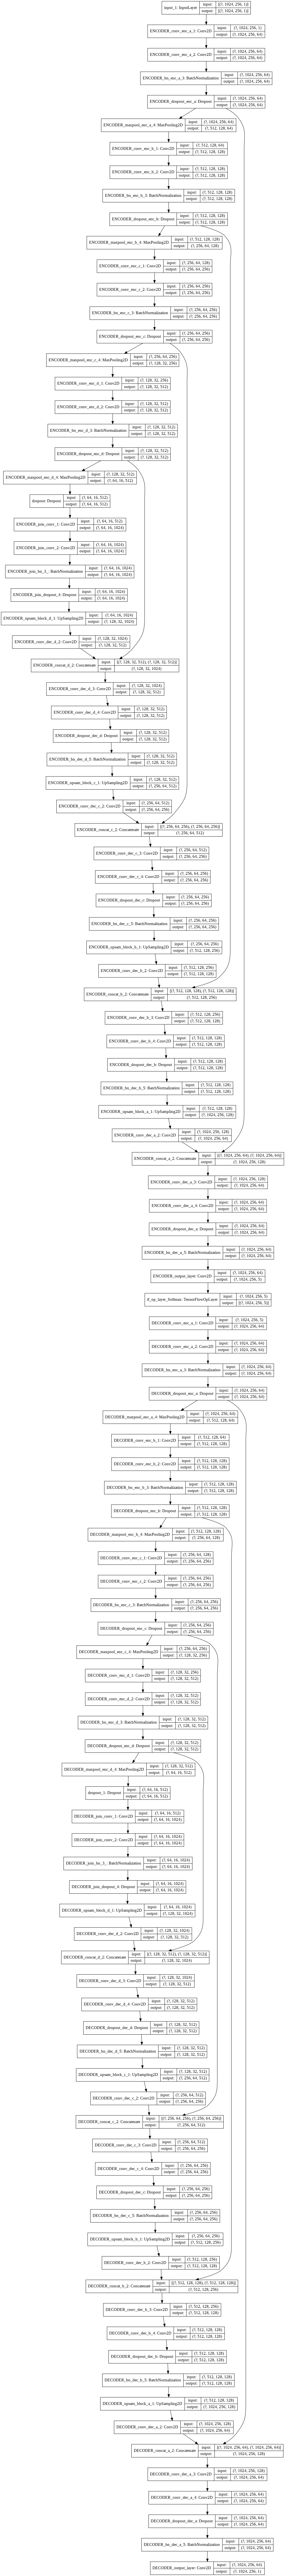

In [23]:
model = wnet(num_classes, size=[img_rows, img_cols, 1])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 256, 1 0                                            
__________________________________________________________________________________________________
ENCODER_conv_enc_a_1 (Conv2D)   (None, 1024, 256, 64 640         input_1[0][0]                    
__________________________________________________________________________________________________
ENCODER_conv_enc_a_2 (Conv2D)   (None, 1024, 256, 64 36928       ENCODER_conv_enc_a_1[0][0]       
__________________________________________________________________________________________________
ENCODER_bn_enc_a_3 (BatchNormal (None, 1024, 256, 64 256         ENCODER_conv_enc_a_2[0][0]       
______________________________________________________________________________________________

## Seting up the model: learning rate, optimizer, loss function and trainable weights

In [25]:
# Instantiate learning rate
start_learning_rate = 1e-3 #0.001
# lr = tf.train.exponential_decay(start_learning_rate, global_step_tensor, 5000, 0.999, staircase=True) #TF1
lr = tf.keras.optimizers.schedules.ExponentialDecay(start_learning_rate, decay_steps=5000, decay_rate=0.999, staircase=True)

# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)

# Instantiate a loss function
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Instantiate the classes assignation
def classes_assign(data):
  copy = data
  no_air_class = copy[:,:,:,1:5]
  no_air_class = tf.reduce_sum(no_air_class, axis = -1)
  air_class = copy[:,:,:,0]
  air_class = air_class[..., tf.newaxis]
  no_air_class = no_air_class[..., tf.newaxis]
  final = tf.concat([air_class, no_air_class], axis=-1)
  return final

# Instantiate the loss functions.
def custom_loss(x, decode, output, y_train):
    output = classes_assign(output)
    loss = loss_fn(y_train, output)
    loss = loss*2
    recons_map = (x, decode)
    recons_loss = tf.map_fn(lambda x: tf.reduce_mean(tf.square(tf.keras.backend.cast(x[0], dtype='float64') - tf.keras.backend.cast(x[1], dtype='float64'))), recons_map, dtype=x.dtype)
    recons_loss = tf.reduce_mean(recons_loss)
    
    return loss, recons_loss


In [26]:
#Defining functions for visualizing

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

# **Training**

# Nuova sezione

In [1]:
#Define training loop

epochs = 10

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    
  

    # Open a GradientTape to record the operations run
    # during the forward pass, which enables autodifferentiation.
    with tf.GradientTape(persistent=True) as tape:

      # Run the forward pass of the layer.
      # The operations that the layer applies
      # to its inputs are going to be recorded
      # on the GradientTape.
      output, decode = model(x_batch_train, training=True)  # Logits for this minibatch

      # Compute the loss value for this minibatch.
      loss, recons_loss = custom_loss(x_batch_train, decode, output, y_batch_train)
      #print(loss)

    vars_encoder=[]
    # Obtain encoder variables
    for var in model.trainable_variables:
      if var.name.startswith("ENCODER"):
        vars_encoder.append(var)

    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.
    enc_grads = tape.gradient(loss, vars_encoder)
    grads = tape.gradient(recons_loss, model.trainable_weights)

    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients(zip(enc_grads, vars_encoder))
    optimizer.apply_gradients(zip(grads, model.trainable_weights))


    #Print result
    pred_mask = output[0]
    fig=plt.figure()
    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Reconstruction']

    fig.add_subplot(1,4,1)
    plt.imshow(np.squeeze(x_batch_train[0]), cmap='gray', aspect='auto')
    fig.add_subplot(1,4,2)
    plt.imshow(np.squeeze(y_batch_train[0]), aspect='auto')
    fig.add_subplot(1,4,3)
    plt.imshow(np.squeeze(create_mask(pred_mask)), aspect='auto')
    fig.add_subplot(1,4,4)
    plt.imshow(np.squeeze(decode[0]), cmap='gray', aspect='auto')
    plt.show()


    # Log every 5 batches.
    if step % 5 == 0:
        print('Training loss (for one batch) at step %s: loss: %s recons_loss: %s' % (step, float(loss), float(recons_loss)))
        print('Seen so far: %s samples' % ((step + 1) * 4))



  # Save network's weights
  checkpoint_path = '/content/drive/My Drive/DatiTesi/Training/cp_recons.ckpt'
  model.save_weights(checkpoint_path)
  clear_output(wait=True)


Start of epoch 0


NameError: ignored

In [ ]:
# Save network's weights
checkpoint_path = '/content/drive/My Drive/DatiTesi/Training/cp.ckpt'
model.save_weights(checkpoint_path)

# Validation and saving data in Matlab

## Define model and load weights

In [ ]:
checkpoint_path ='/content/drive/My Drive/DatiTesi/Training/cp.ckpt'
model = wnet(num_classes, size=[img_rows, img_cols, 1])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.load_weights(checkpoint_path)

In [ ]:
# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

# Nuova sezione

## Validation dataset execution

In [ ]:
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [ ]:

validation_dataset = tf.data.Dataset.from_tensor_slices((valid_Data[0], valid_Data[1])) # Radargram matrix divided in patches
first_step = True

for step, (x_batch_validation, y_batch_validation) in enumerate(test_dataset):


    output, decode = model(x_batch_validation)  # Logits for this minibatch

    # Compute the loss value for this minibatch.
    loss, recons_loss = custom_loss(x_batch_validation, decode, output, y_batch_validation)
    #print(loss)

    # Delete padding
    x_batch_validation = tf.image.resize_with_crop_or_pad(x_batch_validation, img_rows, img_cols)
    decode = tf.image.resize_with_crop_or_pad(decode, img_rows, img_cols)
    output = tf.image.resize_with_crop_or_pad(output, img_rows, img_cols)

    #Print result
    pred_mask = output[0]
    fig=plt.figure()

    fig.add_subplot(1,3,1)
    plt.imshow(np.squeeze(x_batch_validation[0]), cmap='gray', aspect='auto')
    fig.add_subplot(1,3,2)
    plt.imshow(np.squeeze(create_mask(pred_mask)), aspect='auto')
    fig.add_subplot(1,3,3)
    plt.imshow(np.squeeze(decode[0]), cmap='gray', aspect='auto')
    plt.show()
    print(step)

    # Radargram reconstruction
    if first_step == False:
      for element in x_batch_validation:
        original = tf.concat([original, element],1)
      for element in output:
        classified = tf.concat([classified, create_mask(element)],1)
      for element in decode:
        reconstructed = tf.concat([reconstructed, element],1)
    if first_step == True:
      original = x_batch_validation[0]
      original = tf.concat([original, x_batch_validation[1], x_batch_validation[2], x_batch_validation[3]],1)
      classified = create_mask(output[0])
      classified = tf.concat([classified, create_mask(output[1]), create_mask(output[2]), create_mask(output[3])],1)
      reconstructed = decode[0]
      reconstructed = tf.concat([reconstructed, decode[1], decode[2], decode[3]],1)
      first_step = False

    # Log every 5 batches.
    if step % 5 == 0:
        print('Training loss (for one batch) at step %s: loss: %s recons_loss: %s' % (step, float(loss), float(recons_loss)))
        print('Seen so far: %s samples' % ((step + 1) * 4))


# Final results
print('Final recap')
fig1=plt.figure(figsize=(20,10))
fig1.add_subplot(1,3,1)
plt.imshow(np.squeeze(original), cmap='gray', aspect='auto')
fig1.add_subplot(1,3,2)
plt.imshow(np.squeeze(classified), aspect='auto')
fig1.add_subplot(1,3,3)
plt.imshow(np.squeeze(reconstructed), cmap='gray', aspect='auto')
plt.show()

In [ ]:
# Save data in Matlab format (for last batches in epoch)
RadargramClassificationMAT = tf.squeeze(classified).numpy()
RadargramReconstructedMAT = tf.squeeze(reconstructed).numpy()  

sio.savemat('/content/drive/My Drive/DatiTesi/Training/RadargramClassification5.mat', {'vect':RadargramClassificationMAT})
sio.savemat('/content/drive/My Drive/DatiTesi/Training/RadargramReconstructed5.mat', {'vect':RadargramReconstructedMAT})

# Nuova sezione

# Nuova sezione